In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.timeseries import LombScargle
import celerite
from celerite import terms
from scipy.optimize import minimize
import emcee

import matplotlib
matplotlib.interactive('True')
import scienceplots
plt.style.use(['nature', 'science'])
import wise_tools as wtl

Start MCMC


100%|████████████████████████████████████| 20000/20000 [02:45<00:00, 120.54it/s]


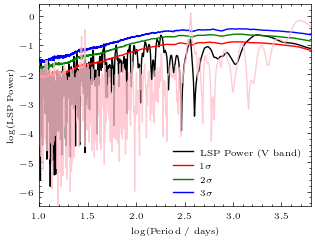

In [2]:
# load light curve
LC_synthetic_V = np.genfromtxt("PKS_J2134-0153_synthetic_V.csv", delimiter=',', names=True)
t_V = LC_synthetic_V["mjd"]
mag_V = LC_synthetic_V["mag"]
mag_err_V = LC_synthetic_V["magerr"]

# reject a few outliers
sel_noout = np.where((mag_V<=20.)&(mag_err_V>0.0), True, False)
t_V = t_V[sel_noout]
mag_V = mag_V[sel_noout]
mag_err_V = mag_err_V[sel_noout]

# time span of the light curve
t_span = t_V[-1] - t_V[0]
fmin = 1/t_span # lowest frequency

# "mean" cadence
p = np.mean(np.diff(t_V))
fmax = 1/(2*p) # highest frequency

N = round(10*t_span*fmax)

# frequency for PSD
frequency_real_V = np.linspace(1/t_span,1/(2*p),N)

ls = LombScargle(t_V, mag_V, mag_err_V, normalization='standard')
power_real_V = ls.power(frequency_real_V)


# initialize the Celerite kernel : 
sigma0 = 0.2 # sighat * sqrt(tau) / sqrt(2)
tau0 = 10
# kernel for DRW
kernel = terms.RealTerm(log_a = 2 * np.log(sigma0) , 
                        log_c = np.log(1.0/tau0))

# define the log likelihood
# we want to maximize the likelihood 
def neg_log_posterior(params, y, gp):  
    # Jeffreys prior 
    # 1 / sigma_hat *  1 / tau 
    gp.set_parameter_vector(params)
    log_a = params[0]
    log_c = params[1]
     # - log_likelihood - log(prior)
    log_prior  = 0.5* (-np.log(2.0) - log_a + log_c  )
    return -gp.log_likelihood(y, quiet=True)  - log_prior

# set boundaries for Celerite 
sig_lims = [1.e-6, 100.]  # mags : consider a broad range 
tau_lims = [5.,50000.] # days : consider a broad range

tau_bounds, sigma_bounds = tau_lims, sig_lims
logc_bounds= (np.log(1/max(tau_bounds)), 
              np.log(1/min(tau_bounds)) )
loga_bounds = (2*np.log(min(sigma_bounds)), 
               2*np.log(max(sigma_bounds)))
bounds = [loga_bounds, logc_bounds]

# copy the V band light curve
t = t_V + 0.
xflux = mag_V + 0.
xerror = mag_err_V + 0.

# call the model  with a chosen kernel instance 
gp = celerite.GP(kernel, mean=np.mean(xflux))
gp.compute(t, xerror)

# set initial params 
initial_params = gp.get_parameter_vector()

# find the minimum of the negative log posterior ... 
r = minimize(neg_log_posterior, initial_params, 
             method="Powell", bounds=bounds, args=(xflux, gp), options={'maxiter': 200000})
gp.set_parameter_vector(r.x)

# retrieve the best-fit parameters 
res = gp.get_parameter_dict()
sigmaMAP = np.exp(res['kernel:log_a']/2) # equivalent to SFinf in astroML
tauMAP = 1.0 / np.exp(res['kernel:log_c'])

#do mcmc to find and verify the solutions
def pos_log_posterior(params, y, gp, p_bound):
    if params[0]>p_bound[0][1] or params[0]<p_bound[0][0] or params[1]>p_bound[1][1] or params[1]<p_bound[1][0]:
        return -np.inf
    else:
        return - neg_log_posterior(params, y, gp)

ndim, nwalkers = 2, 60
p0 = np.random.randn(nwalkers, ndim) * 0.01
p0[:, 0] += r.x[0] # lets's start with a good initial condition
p0[:, 1] += r.x[1]

print('Start MCMC')
sampler = emcee.EnsembleSampler(nwalkers, ndim, pos_log_posterior, args=[xflux, gp, bounds])
sampler.run_mcmc(p0, 20000, progress=True)

# extract the MCMC chains
flat_samples = sampler.get_chain(discard=5000, flat=True)
num_sample = flat_samples.shape[0]


# make mock light curves according to the best DRW parameters
nsim = 20000

nobs = len(xflux)

xflux_median = np.median(xflux)
xflux_mad = 1.48*np.median(np.abs(xflux - xflux_median))

xflux_sim = np.empty((nobs, nsim))
xflux_error = np.empty((nobs, nsim))
trest = np.arange(t[0], t[-1], 1.)

pms_use = np.median(flat_samples, axis=0)
gp.set_parameter_vector(pms_use)

for i in range(nsim):
    # generate a mock light curve
    xflux_sim_tmp = gp.sample(size=1)[0, :]
    xflux_sim_tmp_median = np.median(xflux_sim_tmp)
    xflux_sim_tmp_mad = 1.48*np.median(np.abs(xflux_sim_tmp - xflux_sim_tmp_median))
    # match the median and normalized median absolute deviation of the observed and mock light curves, add measurement errors
    xflux_sim[:, i] = (xflux_sim_tmp - xflux_sim_tmp_median) / xflux_sim_tmp_mad * xflux_mad + xflux_median + np.random.randn(nobs)*xerror
    xflux_error[:, i] = xerror

# save the mock light curves
np.savez("2134-0153(V_unbin)_simulation.npz", t=t, xflux_sim=xflux_sim, t_span=t_span, N=N, p=p, xerror=xflux_error)


# calculate the PSD of all mock light curves
from multiprocessing import Pool
import myfunc_V_unbin

# use multiprocessing to accelerate the calculation
if __name__ == "__main__":
    pp = Pool(processes=8)
    res_l = []
    
    for i in range(20000):
        res = pp.apply_async(myfunc_V_unbin.myfunc, args=(i,))
        res_l.append(res)
    pp.close()
    pp.join()

powers = []
for i in range(20000):
    res = res_l[i]
    powers.append(res.get())

frequency = np.linspace(1/t_span,1/(2*p),N)
# save the PSD
np.savez("2134-0153(V_unbin)_LSP(20000).npz", frequency=frequency, powers=powers)

# PSD of the sampling
f_sample = np.ones(mag_V.shape)
ls_sample = LombScargle(t_V, f_sample)
ps_ls_sample = ls_sample.power(frequency_real_V)

# load the mock PSDs
PSD_mocks = np.load('2134-0153(V_unbin)_LSP(20000).npz')


fig = plt.figure()
# PSD of the true light curve
plt.plot(np.log10(1/frequency_real_V), np.log10(power_real_V), color='black')

# the 1, 2, and 3 sigma of the mock PSDs
sigma1 = np.percentile(PSD_mocks["powers"], [16,84], axis=0)
sigma2 = np.percentile(PSD_mocks["powers"], [2.5,97.5], axis=0)
sigma3 = np.percentile(PSD_mocks["powers"], [0.15,99.85], axis=0)

plt.plot(np.log10(1/frequency_real_V), np.log10(sigma1[1]), color='r')
plt.plot(np.log10(1/frequency_real_V), np.log10(sigma2[1]), color='g')
plt.plot(np.log10(1/frequency_real_V), np.log10(sigma3[1]), color='b')

# PSD of the sampling
plt.plot(np.log10(1/frequency_real_V), np.log10(ps_ls_sample), color='pink', alpha=0.8)

plt.ylabel('log(LSP Power)')
plt.xlabel('log(Period / days) ')

plt.legend(['LSP Power (V band)','1$\sigma$','2$\sigma$','3$\sigma$'],loc='lower right')
plt.ylim([-6.5, 0.4])
plt.xlim([1., 3.8])

#plt.savefig('fig2-1.pdf',dpi=300, bbox_inches='tight')
plt.show()



In [3]:
#Load IR band lighe curves


#Load the ALL WISE data
NEO_WISE = pd.read_csv('J2134-0153_NEOWISE.csv')
t_NEOWISE = NEO_WISE['mjd']
W1_NEOWISE = NEO_WISE['w1mpro']
W1err_NEOWISE = NEO_WISE['w1sigmpro']
W2_NEOWISE = NEO_WISE['w2mpro']
W2err_NEOWISE = NEO_WISE['w2sigmpro']


#remove the bad data
sel_NEOWISE = np.where((NEO_WISE['qi_fact']>=1) & (NEO_WISE['moon_masked']<=0)&(NEO_WISE['saa_sep']>=5), True, False)
t_NEOWISE = t_NEOWISE[sel_NEOWISE]
W1_NEOWISE = W1_NEOWISE[sel_NEOWISE]
W1err_NEOWISE = W1err_NEOWISE[sel_NEOWISE]
W2_NEOWISE = W2_NEOWISE[sel_NEOWISE]
W2err_NEOWISE = W2err_NEOWISE[sel_NEOWISE]





#Load the NEO WISE data
WISE = pd.read_csv('J2134-0153_WISE.csv')
t_WISE = WISE['mjd']
W1_WISE = WISE['w1mpro_ep']
W1err_WISE = WISE['w1sigmpro_ep']
W2_WISE = WISE['w2mpro_ep']
W2err_WISE = WISE['w2sigmpro_ep']


#remove the bad data
sel_WISE = np.where((WISE['qi_fact']>=1) & (WISE['moon_masked']<=0)&(WISE['saa_sep']>=5), True, False)
t_WISE = t_WISE[sel_WISE]
W1_WISE = W1_WISE[sel_WISE]
W1err_WISE = W1err_WISE[sel_WISE]
W2_WISE = W2_WISE[sel_WISE]
W2err_WISE = W2err_WISE[sel_WISE]



#Merge these light curves
t_wise_all = np.append(t_NEOWISE,t_WISE)
W1_all = np.append(W1_NEOWISE,W1_WISE)
W1err_all = np.append(W1err_NEOWISE,W1err_WISE)
W2_all = np.append(W2_NEOWISE,W2_WISE)
W2err_all = np.append(W2err_NEOWISE,W2err_WISE)


#Make sure the time for light curves are increased
seq_WISE_all = np.argsort(t_wise_all)
t_WISE_seq = np.array(t_wise_all[seq_WISE_all])
W1_mag_seq = np.array(W1_all[seq_WISE_all])
W1_mag_err_seq = np.array(W1err_all[seq_WISE_all])
W2_mag_seq = np.array(W2_all[seq_WISE_all])
W2_mag_err_seq = np.array(W2err_all[seq_WISE_all])



t_IR = t_WISE_seq
W1 = W1_mag_seq
W1err = W1_mag_err_seq
W2 = W2_mag_seq
W2err = W2_mag_err_seq


Start MCMC


100%|████████████████████████████████████| 20000/20000 [01:47<00:00, 185.51it/s]
/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in log10


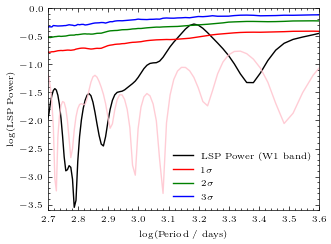

In [4]:
# time span of the light curve
t_span = t_IR[-1] - t_IR[0]
fmin = 1/t_span # lowest frequency

# "mean" cadence
p = np.mean(np.diff(t_IR))
fmax = 1/(2*p) # highest frequency

N = round(10*t_span*fmax)

# frequency for PSD
frequency_real_W1 = np.linspace(1/t_span,1/(2*p),N)

ls = LombScargle(t_IR, W1, W1err, normalization='standard')
power_real_W1 = ls.power(frequency_real_W1)


# initialize the Celerite kernel : 
sigma0 = 0.2 # sighat * sqrt(tau) / sqrt(2)
tau0 = 10
# kernel for DRW
kernel = terms.RealTerm(log_a = 2 * np.log(sigma0) , 
                        log_c = np.log(1.0/tau0))

# define the log likelihood
# we want to maximize the likelihood 
def neg_log_posterior(params, y, gp):  
    # Jeffreys prior 
    # 1 / sigma_hat *  1 / tau 
    gp.set_parameter_vector(params)
    log_a = params[0]
    log_c = params[1]
     # - log_likelihood - log(prior)
    log_prior  = 0.5* (-np.log(2.0) - log_a + log_c  )
    return -gp.log_likelihood(y, quiet=True)  - log_prior

# set boundaries for Celerite 
sig_lims = [1.e-6, 100.]  # mags : consider a broad range 
tau_lims = [5.,50000.] # days : consider a broad range

tau_bounds, sigma_bounds = tau_lims, sig_lims
logc_bounds= (np.log(1/max(tau_bounds)), 
              np.log(1/min(tau_bounds)) )
loga_bounds = (2*np.log(min(sigma_bounds)), 
               2*np.log(max(sigma_bounds)))
bounds = [loga_bounds, logc_bounds]

# copy the W1 band light curve
t = t_IR + 0.
xflux = W1 + 0.
xerror = W1err + 0.

# call the model  with a chosen kernel instance 
gp = celerite.GP(kernel, mean=np.mean(xflux))
gp.compute(t, xerror)

# set initial params 
initial_params = gp.get_parameter_vector()

# find the minimum of the negative log posterior ... 
r = minimize(neg_log_posterior, initial_params, 
             method="Powell", bounds=bounds, args=(xflux, gp), options={'maxiter': 200000})
gp.set_parameter_vector(r.x)

# retrieve the best-fit parameters 
res = gp.get_parameter_dict()
sigmaMAP = np.exp(res['kernel:log_a']/2) # equivalent to SFinf in astroML
tauMAP = 1.0 / np.exp(res['kernel:log_c'])

#do mcmc to find and verify the solutions
def pos_log_posterior(params, y, gp, p_bound):
    if params[0]>p_bound[0][1] or params[0]<p_bound[0][0] or params[1]>p_bound[1][1] or params[1]<p_bound[1][0]:
        return -np.inf
    else:
        return - neg_log_posterior(params, y, gp)

ndim, nwalkers = 2, 60
p0 = np.random.randn(nwalkers, ndim) * 0.01
p0[:, 0] += r.x[0] # lets's start with a good initial condition
p0[:, 1] += r.x[1]

print('Start MCMC')
sampler = emcee.EnsembleSampler(nwalkers, ndim, pos_log_posterior, args=[xflux, gp, bounds])
sampler.run_mcmc(p0, 20000, progress=True)

# extract the MCMC chains
flat_samples = sampler.get_chain(discard=5000, flat=True)
num_sample = flat_samples.shape[0]


# make mock light curves according to the best DRW parameters
nsim = 20000

nobs = len(xflux)

xflux_median = np.median(xflux)
xflux_mad = 1.48*np.median(np.abs(xflux - xflux_median))

xflux_sim = np.empty((nobs, nsim))
xflux_error = np.empty((nobs, nsim))
trest = np.arange(t[0], t[-1], 1.)

pms_use = np.median(flat_samples, axis=0)
gp.set_parameter_vector(pms_use)

for i in range(nsim):
    # generate a mock light curve
    xflux_sim_tmp = gp.sample(size=1)[0, :]
    xflux_sim_tmp_median = np.median(xflux_sim_tmp)
    xflux_sim_tmp_mad = 1.48*np.median(np.abs(xflux_sim_tmp - xflux_sim_tmp_median))
    # match the median and normalized median absolute deviation of the observed and mock light curves, add measurement errors
    xflux_sim[:, i] = (xflux_sim_tmp - xflux_sim_tmp_median) / xflux_sim_tmp_mad * xflux_mad + xflux_median + np.random.randn(nobs)*xerror
    xflux_error[:, i] = xerror

# save the mock light curves
np.savez("2134-0153(W1_unbin)_simulation.npz", t=t, xflux_sim=xflux_sim, t_span=t_span, N=N, p=p, xerror=xflux_error)


# calculate the PSD of all mock light curves
from multiprocessing import Pool
import myfunc_W1_unbin

# use multiprocessing to accelerate the calculation
if __name__ == "__main__":
    pp = Pool(processes=8)
    res_l = []
    
    for i in range(20000):
        res = pp.apply_async(myfunc_W1_unbin.myfunc, args=(i,))
        res_l.append(res)
    pp.close()
    pp.join()

powers = []
for i in range(20000):
    res = res_l[i]
    powers.append(res.get())

frequency = np.linspace(1/t_span,1/(2*p),N)
# save the PSD
np.savez("2134-0153(W1_unbin)_LSP(20000).npz", frequency=frequency, powers=powers)

# PSD of the sampling
f_sample = np.ones(W1.shape)
ls_sample = LombScargle(t_IR, f_sample)
ps_ls_sample = ls_sample.power(frequency_real_W1)

# load the mock PSDs
PSD_mocks = np.load('2134-0153(W1_unbin)_LSP(20000).npz')


fig = plt.figure()
# PSD of the true light curve
plt.plot(np.log10(1/frequency_real_W1), np.log10(power_real_W1), color='black')

# the 1, 2, and 3 sigma of the mock PSDs
sigma1 = np.percentile(PSD_mocks["powers"], [16,84], axis=0)
sigma2 = np.percentile(PSD_mocks["powers"], [2.5,97.5], axis=0)
sigma3 = np.percentile(PSD_mocks["powers"], [0.15,99.85], axis=0)

plt.plot(np.log10(1/frequency_real_W1), np.log10(sigma1[1]), color='r')
plt.plot(np.log10(1/frequency_real_W1), np.log10(sigma2[1]), color='g')
plt.plot(np.log10(1/frequency_real_W1), np.log10(sigma3[1]), color='b')

# PSD of the sampling
plt.plot(np.log10(1/frequency_real_W1), np.log10(ps_ls_sample), color='pink', alpha=0.8)

plt.ylabel('log(LSP Power)')
plt.xlabel('log(Period / days) ')

plt.legend(['LSP Power (W1 band)','1$\sigma$','2$\sigma$','3$\sigma$'],loc='lower right')
plt.ylim([-3.6, 0])
plt.xlim([2.7, 3.6])

#plt.savefig('fig2-2.pdf',dpi=300, bbox_inches='tight')
plt.show()